# Volatility modeling

## Content

- Data
    - Upload and visualize data
    - Preprocess prices and transform to returns
    - Plot histograms and Q-Q plots
    
    
- Modelling volatility
    - GARCH
    - Filtered HS
    
    
- Calculating VaR curve using volatility models
    - Filtered Historical Simulation
    - Parametric estimation
    
    
- Backtesting VaR curve
    - Bernoulli coverage test
    - Independence test
    
    
    
## References
- [Univariate Volatility Modeling](https://www.financialriskforecasting.com/files/Danielsson-Financial-Risk-Forecasting-Slides-2.pdf)


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

## Data

### Upload and visualize data

**Task: download daily data for any company you want, so that you have at least 2 years of history**

In [2]:
import yfinance as yf

prices = yf.download('AAPL','2016-01-01','2022-04-03')

prices.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,26.752501,26.757500,26.205000,26.315001,24.199888,163649200
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.220573,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.613623,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.151514,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.174416,324377600


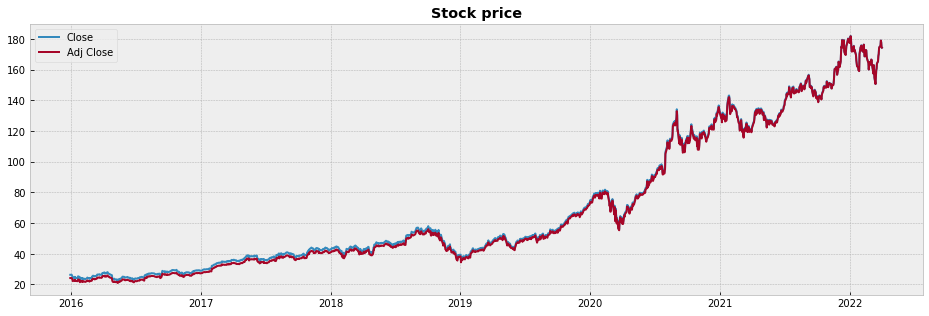

In [3]:
plot_fields =  ['Close', 'Adj Close']

fig = plt.figure(figsize=(16, 5))

plt.plot(prices[plot_fields])
plt.legend(plot_fields)

plt.title("Stock price", weight="bold")

plt.show()

### Preprocess prices and transform to returns

In [4]:
prices.index = prices.index.to_period(freq='d')

price = prices['Adj Close']
ret = price.pct_change()
ret = ret.dropna()

ret

Date
2016-01-04    0.000855
2016-01-05   -0.025059
2016-01-06   -0.019570
2016-01-07   -0.042205
2016-01-08    0.005287
                ...   
2022-03-28    0.005037
2022-03-29    0.019134
2022-03-30   -0.006650
2022-03-31   -0.017776
2022-04-01   -0.001718
Freq: D, Name: Adj Close, Length: 1574, dtype: float64

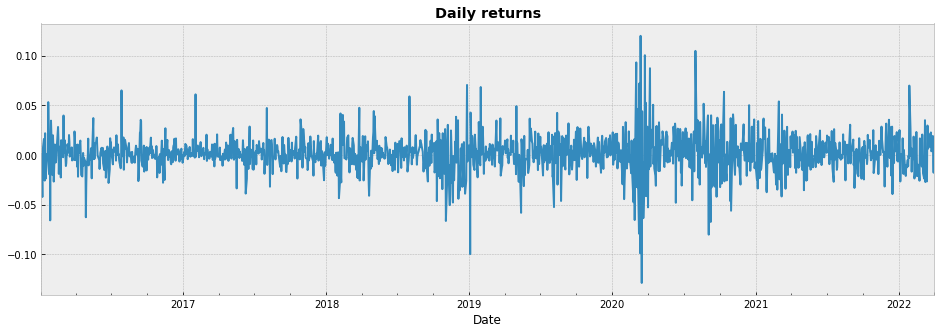

In [6]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
plt.title("Daily returns", weight="bold")

plt.show()

### Plot histograms and Q-Q plots

Explore the Returns Distribution

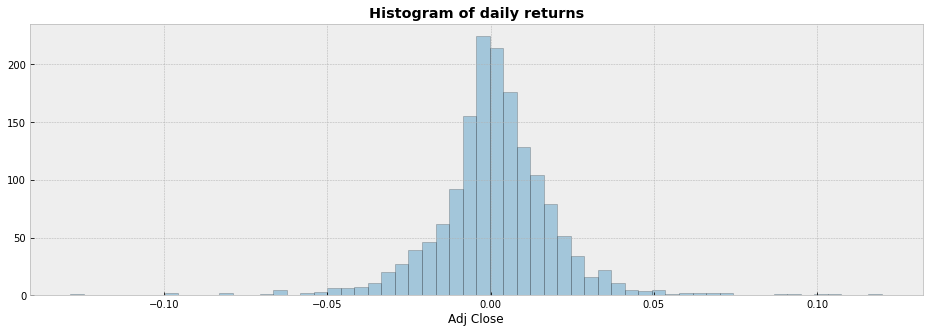

In [7]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(ret, hist=True,
             kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of daily returns", weight="bold")

plt.show()

In [12]:
alpha = 0.05

## Recap -- Historical Simulation

In [13]:
def calculate_VaR_HS(ret, alpha=0.05):

    return ret.quantile(alpha)

def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [14]:
VaR_HS = calc_VaR(ret, calculate_VaR_HS, L_history=252, level=alpha)

VaR_HS

Date
2016-01-04         NaN
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
                ...   
2022-03-28   -0.024222
2022-03-29   -0.024222
2022-03-30   -0.024222
2022-03-31   -0.024222
2022-04-01   -0.024222
Freq: D, Name: calculate_VaR_HS, Length: 1574, dtype: float64

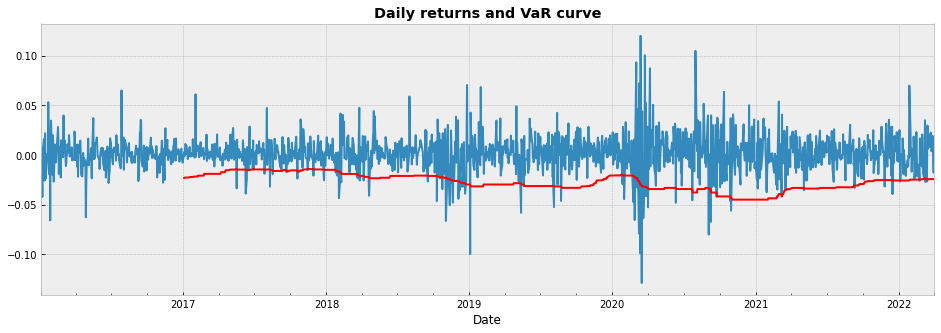

In [15]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot(color='r')

plt.title("Daily returns and VaR curve", weight="bold")

plt.show()

## Volatility

### Simple case of Moving average estimation

Conditional volatility is the average sum of squared returns over the estimation window:

$$\hat{\sigma_{t}^2} = \frac{1}{W_e}\sum_{k=1}^{W_e}r_{t-k}^2$$

**Task: estimate variance using moving average with estimation window of 30 days**

Make `variance_ma` a pd.Series object for visualization

In [16]:
w_est = 28

variance_ma = np.full(ret.size, np.nan)

for i in range(w_est, len(ret)):
    
    history = ret[i - w_est: i]

    variance_ma[i] = np.sum(np.power(history, 2)) / w_est
    
variance_ma = pd.Series(variance_ma, index=ret.index)

In [17]:
variance_ma

Date
2016-01-04         NaN
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
                ...   
2022-03-28    0.000381
2022-03-29    0.000362
2022-03-30    0.000375
2022-03-31    0.000361
2022-04-01    0.000369
Freq: D, Length: 1574, dtype: float64

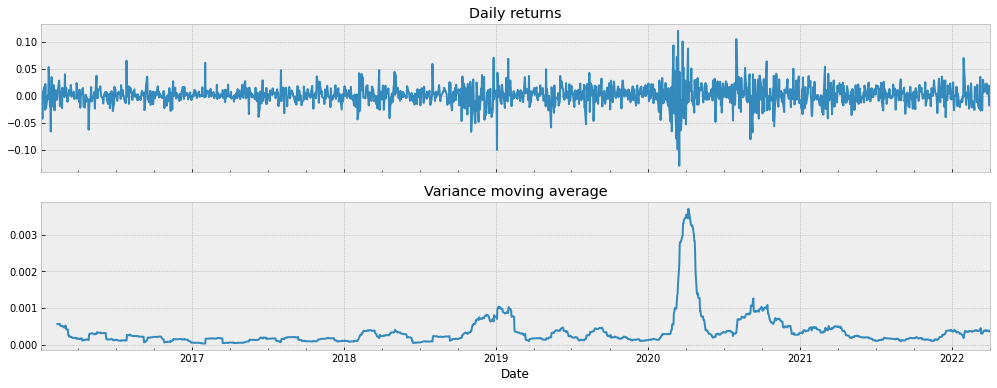

In [18]:
fig = plt.figure(figsize=(17, 6))

plt1 = fig.add_subplot(2,1,1)
plt2 = fig.add_subplot(2,1,2)

ret.plot(ax=plt1.axes)
plt1.set_title('Daily returns')

variance_ma.plot(ax=plt2.axes)
plt2.set_title('Variance moving average')

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

### GARCH models

And here we start assuming dependency between $r_t$ and $r_{t+h}$, and we will use Conditional volatility models. Facts motivating these models:
1. Returns are not linearly autocorrelated
2. The ACF of squared returns dies out exponentially
3. Volatility is time-varying

Main assumption: Conditional returns are iid normally distributed with time-varying variance

$$r_{t+1} = \mu_t  + \sqrt{h_t}\epsilon_t \text{  with  } \epsilon_t \sim N(0, 1)$$

$$\mu_{t+1} = F(r_t, r_{t-1}, ...)$$

$$h_{t+1} = G(r^2_t, r^2_{t-1}, ...)$$


For example, ARMA-GARCH model could be written as:

$$\mu_{t+1} = a + \sum_0^k c_ir_{t-i} + \sum_0^m d_i\epsilon_{t-i}$$

$$h_{t+1} = \omega + \sum_0^p \alpha_ir^2_{t-i} + \sum_0^q \beta_ih_{t-i}$$


Also, $\epsilon_t$ can have some other distribution $\epsilon_t \sim F(x; \theta)$


$$r_{t+1} \sim \mu_{t+1}  + \sqrt{h_{t+1}} \epsilon_t$$


#### GARCH with parametric distribution of residuals

I ecourage you too look at the following pages with formulas
- https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html
- https://arch.readthedocs.io/en/latest/univariate/forecasting.html

In [ ]:
# https://arch.readthedocs.io/en/latest/univariate/introduction.html
!pip install arch

In [1]:
from arch import arch_model

help(arch_model)

Help on function arch_model in module arch.univariate.mean:

arch_model(y: 'Optional[ArrayLike]', x: 'Optional[ArrayLike]' = None, mean: "Literal[('Constant', 'Zero', 'LS', 'AR', 'ARX', 'HAR', 'HARX', 'constant', 'zero')]" = 'Constant', lags: 'Union[None, int, List[int], Int32Array, Int64Array]' = 0, vol: "Literal[('GARCH', 'ARCH', 'EGARCH', 'FIARCH', 'APARCH', 'HARCH')]" = 'GARCH', p: 'Union[int, List[int]]' = 1, o: 'int' = 0, q: 'int' = 1, power: 'float' = 2.0, dist: "Literal[('normal', 'gaussian', 't', 'studentst', 'skewstudent', 'skewt', 'ged', 'generalized error')]" = 'normal', hold_back: 'Optional[int]' = None, rescale: 'Optional[bool]' = None) -> 'HARX'
    Initialization of common ARCH model specifications
    
    Parameters
    ----------
    y : {ndarray, Series, None}
        The dependent variable
    x : {np.array, DataFrame}, optional
        Exogenous regressors.  Ignored if model does not permit exogenous
        regressors.
    mean : str, optional
        Name of the



**Task: Fit a default model without any params**

Note: for numerical optimization purposes, it is better to scale your returns series to a scale of one. Don't forget to re-scale it after

For simplicity now, just pass returns multiplied by 100

In [21]:
from arch import arch_model 

mdl = arch_model(100 * ret) # * 100 because it asked to do so
res = mdl.fit()

res

Iteration:      1,   Func. Count:      6,   Neg. LLF: 11451.127971290303
Iteration:      2,   Func. Count:     14,   Neg. LLF: 3263.117149816758
Iteration:      3,   Func. Count:     20,   Neg. LLF: 850180323.0218563
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3647.68337567475
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3047.2912218498277
Iteration:      6,   Func. Count:     38,   Neg. LLF: 9948.499814042741
Iteration:      7,   Func. Count:     44,   Neg. LLF: 3017.6967325169426
Iteration:      8,   Func. Count:     50,   Neg. LLF: 3004.438973981889
Iteration:      9,   Func. Count:     55,   Neg. LLF: 3004.429497881105
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3004.4293738899214
Iteration:     11,   Func. Count:     65,   Neg. LLF: 3004.4293211862964
Iteration:     12,   Func. Count:     70,   Neg. LLF: 3004.4293199320923
Iteration:     13,   Func. Count:     74,   Neg. LLF: 3004.4293199319177
Optimization terminated successfully    (Exit mode 0)
    

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3004.43
Distribution:                  Normal   AIC:                           6016.86
Method:            Maximum Likelihood   BIC:                           6038.30
                                        No. Observations:                 1574
Date:                Mon, Apr 04 2022   Df Residuals:                     1573
Time:                        10:36:44   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2211  4.119e-02      5.367  8.004e-08 [  0.140,  0.30

**Task: Play with parameters and print results again**

You can use:
- `mean` and `lags` -- to specify model for mean
- `vol`, `p`, `q` and `o` -- to specify model for variance
- `dist` -- to specify distribution for normalized residuals

In [22]:
dist = 'skewstudent'

mdl = arch_model(
    y=100 * ret,
    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
    dist=dist # dist = Normal, t, skewstudent, ged
) 

res = mdl.fit()
res

Iteration:      1,   Func. Count:     10,   Neg. LLF: 38198.326986216125
Iteration:      2,   Func. Count:     23,   Neg. LLF: 41719.93453674183
Iteration:      3,   Func. Count:     35,   Neg. LLF: 73106.32494570187
Iteration:      4,   Func. Count:     46,   Neg. LLF: 24971.072289583484
Iteration:      5,   Func. Count:     57,   Neg. LLF: 30965.23205726152
Iteration:      6,   Func. Count:     68,   Neg. LLF: 4370.257563523339
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4280.4664140922505
Iteration:      8,   Func. Count:     89,   Neg. LLF: 3961.223362763233
Iteration:      9,   Func. Count:     99,   Neg. LLF: 2906.9912140611823
Iteration:     10,   Func. Count:    109,   Neg. LLF: 2940.913152539999
Iteration:     11,   Func. Count:    120,   Neg. LLF: 2905.256126041646
Iteration:     12,   Func. Count:    129,   Neg. LLF: 2905.198862093933
Iteration:     13,   Func. Count:    138,   Neg. LLF: 2905.196408977303
Iteration:     14,   Func. Count:    147,   Neg. LLF: 2905.1

                              HAR - GJR-GARCH Model Results                              
Dep. Variable:                         Adj Close   R-squared:                       0.001
Mean Model:                                  HAR   Adj. R-squared:                  0.001
Vol Model:                             GJR-GARCH   Log-Likelihood:               -2905.20
Distribution:      Standardized Skew Student's t   AIC:                           5826.39
Method:                       Maximum Likelihood   BIC:                           5869.28
                                                   No. Observations:                 1573
Date:                           Mon, Apr 04 2022   Df Residuals:                     1571
Time:                                   10:41:21   Df Model:                            2
                                    Mean Model                                    
                      coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------

Here we can see fitted conditional volatility and standartized residuals

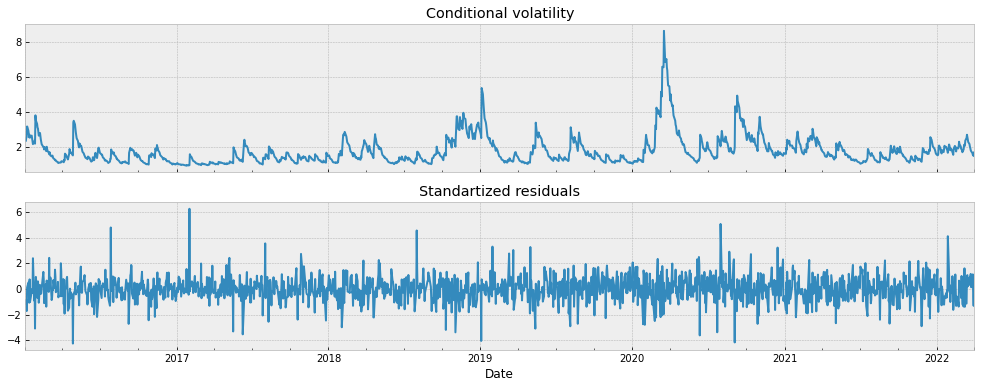

In [23]:
fig = plt.figure(figsize=(17, 6))

plt1 = fig.add_subplot(2,1,1)
plt2 = fig.add_subplot(2,1,2)

res.conditional_volatility.plot(ax=plt1.axes)
plt1.set_title('Conditional volatility')

(res.resid / res.conditional_volatility).plot(ax=plt2.axes)
plt2.set_title('Standartized residuals')

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

**Learn how to do forecast of conditional mean and variance**

In [24]:
my_forecast = res.forecast(horizon=5)

print(my_forecast.mean.tail(4))
print(my_forecast.variance.tail(4))

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2022-03-29       NaN       NaN       NaN       NaN       NaN
2022-03-30       NaN       NaN       NaN       NaN       NaN
2022-03-31       NaN       NaN       NaN       NaN       NaN
2022-04-01  0.154044  0.151661  0.151678  0.151678  0.151678
               h.1       h.2      h.3       h.4      h.5
Date                                                    
2022-03-29     NaN       NaN      NaN       NaN      NaN
2022-03-30     NaN       NaN      NaN       NaN      NaN
2022-03-31     NaN       NaN      NaN       NaN      NaN
2022-04-01  2.4999  2.562804  2.62426  2.684426  2.74333


**Check and interpret probability plot**

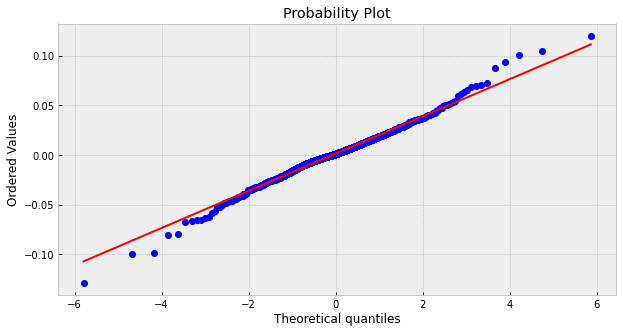

In [25]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=mdl.distribution, sparams=(res.params[-2:],), plot=plt)
plt.show()

**Task: Inplement Filtered Historical Simulation**

Steps:
- fit a model
- get Standartized residuals
- forecast mean and variance one step ahead
- use forecasts and Standartized residuals to get a distribution for Conditional residuals
- calculate VaR as quantile

In [21]:
# fit the model with normal ditribution
mdl = arch_model(
    100 * ret,
    mean='Constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
    vol='Garch', p=2, o=2, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='normal'
                )

res = mdl.fit(disp='off')

# get Standartized residuals
stand_residuals = res.resid / res.conditional_volatility
stand_residuals = stand_residuals.dropna()


# forecast mean and variance one step ahead
forecasts = res.forecast(horizon=1)
cond_mean = float(forecasts.mean.iloc[-1])
cond_var = float(forecasts.variance.iloc[-1])


# conditional stand_residuals
conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
conditional_sr = conditional_sr / 100


# calculate VaR as quantile
VaR_FHS = conditional_sr.quantile(alpha)

In [22]:
conditional_sr

Date
2016-01-04    0.001287
2016-01-05   -0.010614
2016-01-06   -0.008110
2016-01-07   -0.016038
2016-01-08    0.002962
                ...   
2019-12-23    0.015265
2019-12-24    0.000992
2019-12-26    0.019225
2019-12-27   -0.000334
2019-12-30    0.005908
Freq: D, Length: 1005, dtype: float64

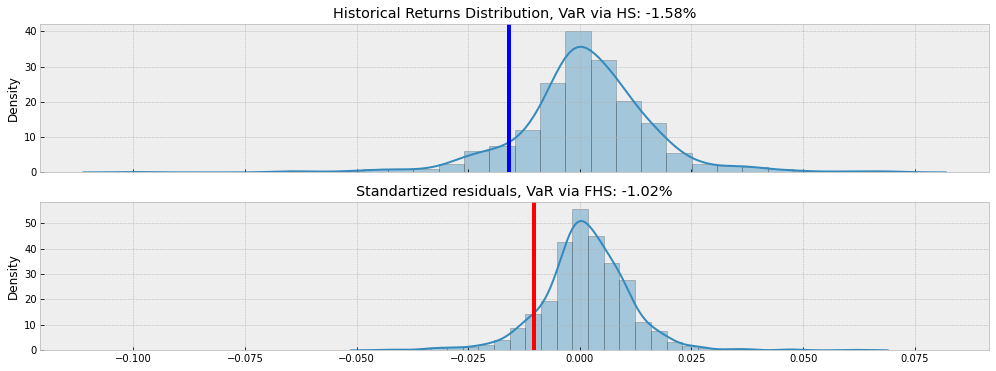

In [23]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(17, 6))

VaR_HS_10 = np.quantile(ret, alpha)

sns.distplot(ret, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'}, ax=ax[0])
ax[0].set_title('Historical Returns Distribution, VaR via HS: {:.2f}%'.format(100*VaR_HS_10))
ax[0].axvline(x=VaR_HS_10, linewidth=4, color="b")

sns.distplot(conditional_sr, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'}, ax=ax[1])
ax[1].set_title('Standartized residuals, VaR via FHS: {:.2f}%'.format(100*VaR_FHS))
ax[1].axvline(x=VaR_FHS, linewidth=4, color="r")

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

**Task: Wrap everything into functions and do a backtest**

In [24]:
def calculate_VaR_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 'skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast


def calculate_VaR_FHS(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    mdl = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='normal')

    res = mdl.fit(disp='off')

   # get Standartized residuals
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()


    # forecast mean and variance one step ahead
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # conditional stand_residuals
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const

    # calculate VaR as quantile
    VaR_FHS = conditional_sr.quantile(alpha)

    return VaR_FHS

In [25]:
VaR_FHS = calc_VaR(ret, calculate_VaR_FHS, L_history=252, level=alpha)

In [31]:
VaR_garch = calc_VaR(ret, calculate_VaR_garch, L_history=252, level=alpha)


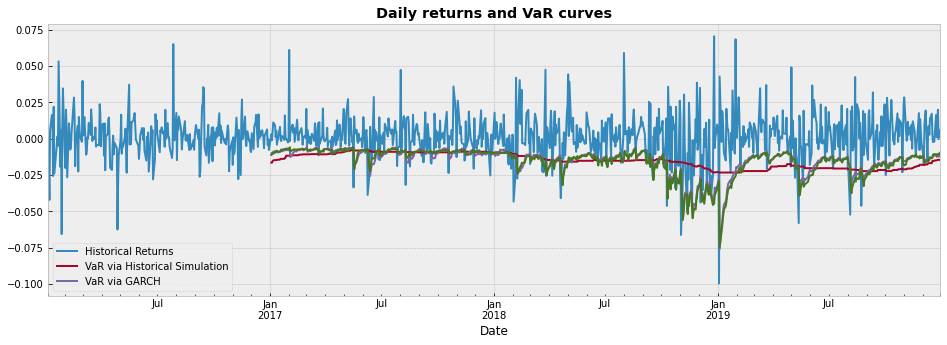

In [32]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot()
# VaR_t.plot()
VaR_garch.plot()
VaR_FHS.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
           'VaR via GARCH',
#            'VaR via Filtered HS'
           ])

plt.show()

## Backtesting VaR

In [33]:
def bern_test(p, v):
    
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))


def ind_test(V):
    
    J = np.full([len(V),4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
        
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))

In [34]:
def backtest_results(ret, var_curve, alpha, significance=0.95):
    
    idx = var_curve.notna()
    
    violations = ret[idx] < var_curve[idx]
    
    coverage = bern_test(p=alpha, v=violations) < ss.chi2.ppf(significance, 1)
    independence = ind_test(violations) < ss.chi2.ppf(significance, 1)
        
    print('Target share of violations: {:.2f}%'.format(100*alpha))
    print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))
    
    print('')
    
    if coverage:
        print('Test for coverage is passed')
    else:
        print('Test for coverage isn\'t passed')
        
    print('')
        
    if independence:
        print('Test for independence is passed')
    else:
        print('Test for independence isn\'t passed')

In [36]:
backtest_results(
    ret, 
    var_curve=VaR_HS,
    alpha=alpha, 
    significance=0.95
)

Target share of violations: 10.00%
Observed share of violations: 11.42%

Test for coverage is passed

Test for independence isn't passed


In [35]:
backtest_results(
    ret, 
    var_curve=VaR_garch,
    alpha=alpha, 
    significance=0.95
)

Target share of violations: 10.00%
Observed share of violations: 10.23%

Test for coverage is passed

Test for independence is passed


In [30]:
backtest_results(
    ret, 
    var_curve=VaR_FHS,
    alpha=alpha, 
    significance=0.95
)

Target share of violations: 10.00%
Observed share of violations: 10.23%

Test for coverage is passed

Test for independence is passed
